# De Bruijn Graph Genome Assembly

This notebook demonstrates the usage of the DBG Assembly package for genome assembly from FASTQ files.

In [11]:
# Import necessary modules
import sys
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Make sure the package is in the Python path
# Change this path to where you've placed the dbg_assembly package
sys.path.append('..')

# Import modules from the package
from dbg_assembly.fastq_parser import FastqParser
from dbg_assembly.kmer_generator import KmerGenerator
from dbg_assembly.de_bruijn_graph import DeBruijnGraph
from dbg_assembly.path_finder import PathFinder
from dbg_assembly.contig_generator import ContigGenerator
from dbg_assembly.fasta_writer import FastaWriter
from dbg_assembly.assembly_metrics import AssemblyMetrics
from dbg_assembly.gfa_export import GfaExporter
from dbg_assembly.visualize import Visualizer

## 1. Load and Parse FASTQ Data

Let's start by loading the FASTQ data from one of the synthetic datasets.

In [2]:
# Path to the FASTQ file
fastq_file = "data/toy_dataset/reads_b.fastq"

# Parse the FASTQ file
parser = FastqParser(fastq_file)
sequences = list(parser.parse())

print(f"Loaded {len(sequences)} sequences")
print(f"Example sequence: {sequences[0][:50]}...")

Loaded 5000 sequences
Example sequence: CCTAAGAAATGGGACGGAATGGCACATTCTCACGGGAACGGGCTGGAAGC...


## 2. Build De Bruijn Graph

Now we'll build a De Bruijn Graph from the sequences with a specific k-mer length.

In [3]:
# Choose a k-mer length
k = 40

# Create and build the De Bruijn Graph
dbg = DeBruijnGraph(k)

for seq in sequences:
    dbg.add_sequence(seq)

print(f"Graph built with {len(dbg.graph.nodes())} nodes and {len(dbg.graph.edges())} edges")

Graph built with 1002 nodes and 1002 edges


## 3. Visualize the Graph

Let's visualize the graph structure to understand its topology.

In [4]:
# Visualize the graph (only if it's small enough to render)
if len(dbg.graph.nodes()) <= 100:  # Don't try to visualize very large graphs
    Visualizer.plot_graph(dbg)
else:
    print("Graph too large to visualize directly. Exporting to GFA for Bandage visualization.")
    
    # Export to GFA
    gfa_file = "output_graph.gfa"
    exporter = GfaExporter(gfa_file)
    exporter.export_graph(dbg)
    print(f"Graph exported to {gfa_file}")

Graph too large to visualize directly. Exporting to GFA for Bandage visualization.
Graph exported to output_graph.gfa


## 4. Find Contigs

Now we'll identify contigs by finding non-branching paths in the graph.

In [5]:
# Find contig paths
contig_paths = PathFinder.find_contigs(dbg)
print(f"Found {len(contig_paths)} contig paths")

# Generate contig sequences
contig_generator = ContigGenerator()
contigs = contig_generator.generate_contigs_from_paths(contig_paths, k)

# Filter out very short contigs
min_length = 100
filtered_contigs = contig_generator.filter_contigs(contigs, min_length)

print(f"Generated {len(contigs)} contigs")
print(f"After filtering (min length {min_length}): {len(filtered_contigs)} contigs")

Found 4 contig paths
Generated 4 contigs
After filtering (min length 100): 2 contigs


## 5. Analyze Contig Properties

Let's check the properties of our generated contigs.

Longest contig: 668 bp
Shortest contig: 330 bp
Average contig length: 499.00 bp


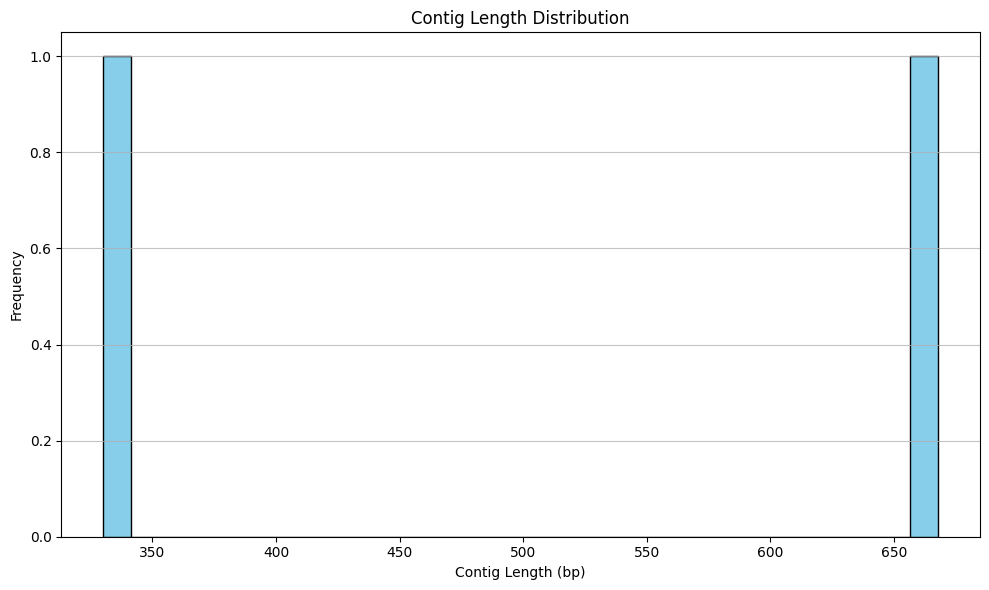

In [6]:
# Display some basic info about the contigs
contig_lengths = [len(contig) for contig in filtered_contigs]

print(f"Longest contig: {max(contig_lengths)} bp")
print(f"Shortest contig: {min(contig_lengths)} bp")
print(f"Average contig length: {sum(contig_lengths) / len(contig_lengths):.2f} bp")

# Visualize contig length distribution
Visualizer.plot_contig_length_distribution(filtered_contigs)

## 6. Calculate Assembly Metrics

Now we'll calculate various metrics to evaluate our assembly.

In [7]:
# Calculate assembly metrics
metrics = AssemblyMetrics.calculate_basic_metrics(filtered_contigs)

# Display metrics in a nice format
print("Assembly Metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value}")

Assembly Metrics:
  total_length: 998
  num_contigs: 2
  mean_length: 499.0
  median_length: 499.0
  max_length: 668
  min_length: 330
  n50: 668
  n90: 330
  l50: 1
  gc_content: 0.5200400801603207


## 7. Write Contigs to FASTA

Finally, let's save our assembly to a FASTA file.

In [8]:
# Write contigs to FASTA file
output_file = "contigs_k40.fasta"
writer = FastaWriter(output_file)
writer.write_contigs(filtered_contigs)

print(f"Contigs written to {output_file}")

Contigs written to contigs_k40.fasta


## 8. Compare with Reference (if available)

If we have a reference genome, we can compare our assembly to it.

In [9]:
# Load reference genome if available
reference_file = "data/toy_dataset/reference_b.fasta"

try:
    with open(reference_file, 'r') as f:
        # Skip header line
        header = f.readline()
        # Read reference sequence
        reference = ''.join(line.strip() for line in f)
        
    print(f"Loaded reference genome: {len(reference)} bp")
    
    # Compare assembly to reference
    comparison_metrics = AssemblyMetrics.compare_to_reference(filtered_contigs, reference)
    
    print("\nComparison to Reference:")
    for metric, value in comparison_metrics.items():
        print(f"  {metric}: {value}")
        
except FileNotFoundError:
    print(f"Reference file {reference_file} not found. Skipping comparison.")

Loaded reference genome: 1000 bp

Comparison to Reference:
  reference_length: 1000
  kmer_recall: 0.9670103092783505
  estimated_genome_fraction: 0.9670103092783505


## 9. Experiment with Different k-mer Sizes

Let's try different k-mer sizes and compare the results.


Assembling with k=35...
  Contigs: 2
  Total length: 998 bp
  N50: 668

Assembling with k=40...
  Contigs: 2
  Total length: 998 bp
  N50: 668

Assembling with k=45...
  Contigs: 2
  Total length: 998 bp
  N50: 668

Assembling with k=50...
  Contigs: 2
  Total length: 1049 bp
  N50: 719


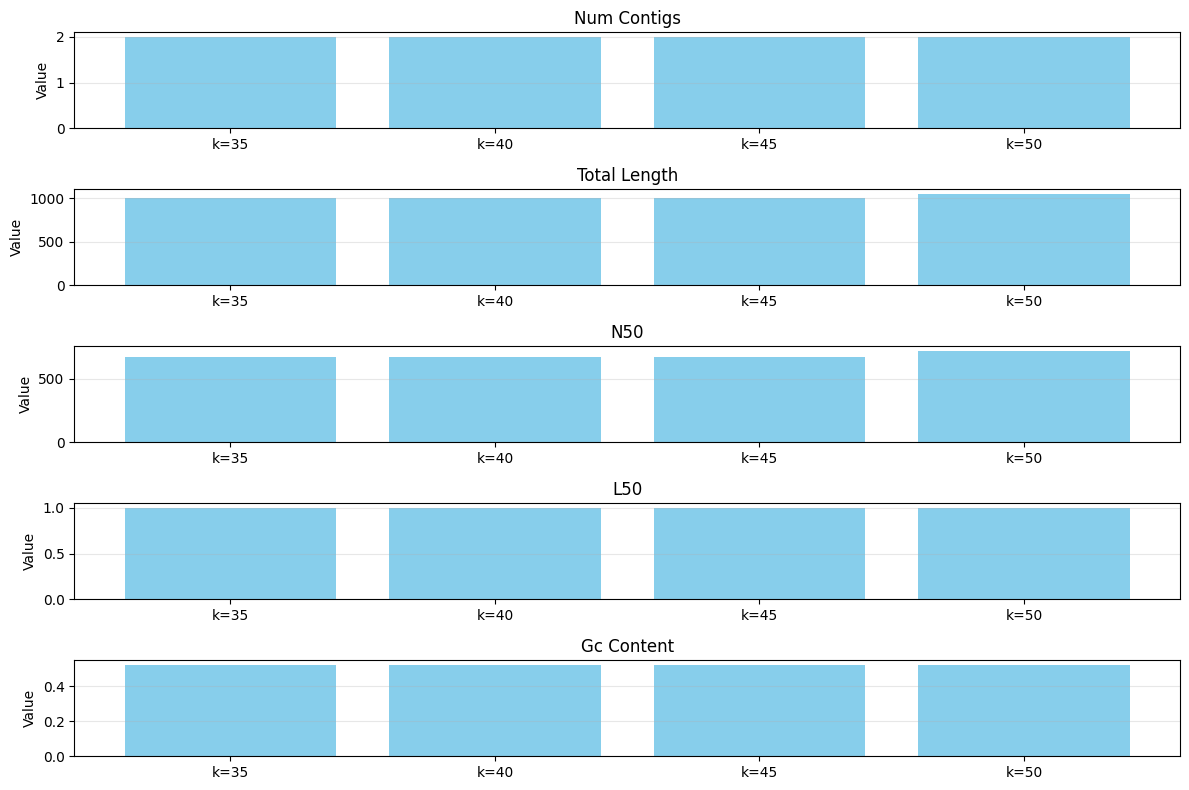

In [10]:
# Function to run assembly with a specific k-mer size
def assemble_with_k(sequences, k, min_length=100):
    # Build graph
    dbg = DeBruijnGraph(k)
    for seq in sequences:
        dbg.add_sequence(seq)
    
    # Find contigs
    contig_paths = PathFinder.find_contigs(dbg)
    contig_generator = ContigGenerator()
    contigs = contig_generator.generate_contigs_from_paths(contig_paths, k)
    filtered_contigs = contig_generator.filter_contigs(contigs, min_length)
    
    # Calculate metrics
    metrics = AssemblyMetrics.calculate_basic_metrics(filtered_contigs)
    
    return filtered_contigs, metrics

# Try different k-mer sizes
k_values = [35, 40, 45, 50]
results = {}

for k in k_values:
    print(f"\nAssembling with k={k}...")
    contigs, metrics = assemble_with_k(sequences, k)
    results[k] = (contigs, metrics)
    
    print(f"  Contigs: {metrics['num_contigs']}")
    print(f"  Total length: {metrics['total_length']} bp")
    print(f"  N50: {metrics['n50']}")
    
    # Write to FASTA
    output_file = f"contigs_k{k}.fasta"
    writer = FastaWriter(output_file)
    writer.write_contigs(contigs)
    
# Compare metrics across different k-values
metrics_list = [results[k][1] for k in k_values]
Visualizer.plot_metrics_comparison(metrics_list, [f"k={k}" for k in k_values])

## 10. Conclusion

We've successfully implemented and tested a De Bruijn Graph assembly algorithm. The results show how different k-mer sizes affect the assembly quality, with trade-offs between contig length, number, and accuracy.

In [13]:
# import os; os.chdir('dbg_assembly'); sys.path.append('..')

In [16]:
# Process reads_b.fastq with k=40, generate contigs and export graph
!python main.py --fastq ../data/toy_dataset/reads_b.fastq --kmer 40 --output results/toy_b_k40.fasta --gfa results/toy_b_k40.gfa --verbose

/home/sabbam0a/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Starting De Bruijn Graph assembly with k=40
Reading sequences from ../data/toy_dataset/reads_b.fastq...
Read 5000 sequences
Building De Bruijn Graph...
De Bruijn Graph built with 1002 nodes and 1002 edges
Finding contigs...
Found 4 contig paths
Generating contig sequences...
Writing 4 contigs to results/toy_b_k40.fasta...
Exporting graph to GFA format: results/toy_b_k40.gfa
Calculating assembly metrics...

Assembly Metrics:
  total_length: 1158
  num_contigs: 4
  mean_length: 289.5
  median_length: 205.0
  max_length: 668
  min_length: 80
  n50: 668
  n90: 80
  l50: 1
  gc_content: 0.5259067357512953


In [17]:
# Process reads_r.fastq with k=35 
!python main.py --fastq ../data/toy_dataset/reads_b.fastq --kmer 35 --output results/toy_r_k35.fasta --verbose

/home/sabbam0a/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Starting De Bruijn Graph assembly with k=35
Reading sequences from ../data/toy_dataset/reads_b.fastq...
Read 5000 sequences
Building De Bruijn Graph...
De Bruijn Graph built with 1002 nodes and 1002 edges
Finding contigs...
Found 4 contig paths
Generating contig sequences...
Writing 4 contigs to results/toy_r_k35.fasta...
Calculating assembly metrics...

Assembly Metrics:
  total_length: 1138
  num_contigs: 4
  mean_length: 284.5
  median_length: 200.0
  max_length: 668
  min_length: 70
  n50: 668
  n90: 70
  l50: 1
  gc_content: 0.5246045694200352


In [18]:
# Process reads_r.fastq with k=45
!python main.py --fastq ../data/toy_dataset/reads_b.fastq --kmer 45 --output results/toy_r_k45.fasta --verbose

/home/sabbam0a/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Starting De Bruijn Graph assembly with k=45
Reading sequences from ../data/toy_dataset/reads_b.fastq...
Read 5000 sequences
Building De Bruijn Graph...
De Bruijn Graph built with 1002 nodes and 1002 edges
Finding contigs...
Found 4 contig paths
Generating contig sequences...
Writing 4 contigs to results/toy_r_k45.fasta...
Calculating assembly metrics...

Assembly Metrics:
  total_length: 1178
  num_contigs: 4
  mean_length: 294.5
  median_length: 210.0
  max_length: 668
  min_length: 90
  n50: 668
  n90: 90
  l50: 1
  gc_content: 0.5220713073005093
